In [1]:
!pip install nbimporter

In [2]:
import numpy as np
import pandas as pd
import nbimporter 
import matrix_factorization
np.random.seed(0)

Importing Jupyter notebook from matrix_factorization.ipynb


In [3]:
# Downloading Movielens-1m
!curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cd ml-1m/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5778k    0 21621    0     0  22220      0  0:04:26 --:--:--  0:04:26 22220
 18 5778k   18 1077k    0     0   509k      0  0:00:11  0:00:02  0:00:09  509k
 46 5778k   46 2673k    0     0   911k      0  0:00:06  0:00:02  0:00:04  911k
 80 5778k   80 4647k    0     0  1192k      0  0:00:04  0:00:03  0:00:01 1192k
100 5778k  100 5778k    0     0  1316k      0  0:00:04  0:00:04 --:--:-- 1316k
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
‘ЁбвҐ¬Ґ ­Ґ г¤ Ґвбп ­ ©вЁ гЄ § ­­л© Їгвм.


In [6]:
import zipfile
with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [7]:
ratings_list = [i.strip().split("::") for i in open('./ml-1m/ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('./ml-1m/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('./ml-1m/movies.dat', 'r').readlines()]

ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [8]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
R_df.shape

(6040, 3706)

In [10]:
np.array(R_df.values, dtype=int)

array([[5, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [12]:
# names = ['user_id', 'item_id', 'rating', 'timestamp']
# df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
# df.head()

In [13]:
# n_users = df.user_id.unique().shape[0]
# n_items = df.item_id.unique().shape[0]
# ratings = np.zeros((n_users, n_items))
# for row in df.itertuples():
#     ratings[row[1]-1, row[2]-1] = row[3]
# ratings

In [14]:
ratings = np.array(R_df.values, dtype=int)
n_users = ratings.shape[0]
n_items = ratings.shape[1]

In [15]:
def get_sparsity(mat):
    print (str(n_users) + ' users')
    print (str(n_items) + ' items')
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [16]:
print ('Sparsity: {:4.2f}%'.format(get_sparsity(ratings)))

6040 users
3706 items
Sparsity: 4.47%


In [17]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], size=20, replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
    
#     print(test)
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [18]:
train, test = train_test_split(ratings)

In [19]:
train.shape

(6040, 3706)

In [20]:
test.shape

(6040, 3706)

In [21]:
ratings

array([[5, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
get_sparsity(ratings)

6040 users
3706 items


4.468362562231285

In [23]:
get_sparsity(train)

6040 users
3706 items


3.9286971547839014

In [24]:
get_sparsity(test)

6040 users
3706 items


0.5396654074473827

In [25]:
MF_SGD = matrix_factorization.ExplicitMF(train, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [10]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 10
	current iteration: 10
Train mse: 0.8264795643096374
Test mse: 0.9051574489352089


##################################################################################################################

# ####################################### GANS ###################################################

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
import torchvision.datasets as datasets
from torchvision import transforms

In [27]:
batch_size = 5

In [28]:
def make_some_noise(batch_size):
    return torch.rand(batch_size,100)

In [29]:
make_some_noise(batch_size)

tensor([[0.1474, 0.4041, 0.9266, 0.8344, 0.0607, 0.2055, 0.1804, 0.0571, 0.4477,
         0.9110, 0.6711, 0.7431, 0.1136, 0.5251, 0.9401, 0.2184, 0.7752, 0.4742,
         0.4788, 0.6751, 0.0654, 0.4542, 0.4279, 0.1089, 0.7128, 0.4631, 0.8986,
         0.4779, 0.2469, 0.5552, 0.6571, 0.4859, 0.2940, 0.1368, 0.3363, 0.2028,
         0.8328, 0.9889, 0.3798, 0.6714, 0.4464, 0.2448, 0.3737, 0.3871, 0.0631,
         0.8536, 0.3421, 0.4817, 0.3166, 0.8078, 0.4534, 0.7482, 0.3868, 0.9344,
         0.6995, 0.4715, 0.5936, 0.1676, 0.0990, 0.9420, 0.8569, 0.9895, 0.9712,
         0.3469, 0.5302, 0.3782, 0.8043, 0.3108, 0.5110, 0.0579, 0.7652, 0.7038,
         0.9826, 0.5229, 0.1523, 0.5841, 0.5733, 0.7517, 0.1006, 0.2259, 0.0476,
         0.5392, 0.3839, 0.1672, 0.2411, 0.0920, 0.9446, 0.8182, 0.8028, 0.3419,
         0.1951, 0.9592, 0.1417, 0.7151, 0.8432, 0.9255, 0.4445, 0.8176, 0.5176,
         0.8171],
        [0.9218, 0.0678, 0.7880, 0.4564, 0.7748, 0.0275, 0.7941, 0.6963, 0.9955,
         0

In [30]:
# defining generator class

class generator(nn.Module):
    
    def __init__(self, inp, out):
        
        super(generator, self).__init__()
        
        self.net = nn.Sequential(
                                 nn.Linear(inp,300),
                                 nn.Tanh(),
                                 nn.Linear(300,1000),
                                 nn.Tanh(),
                                 nn.Linear(1000,800),
                                 nn.Tanh(),
                                 nn.Linear(800,out),
                                 nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.net(x)
        return x*5 # to get values in range [0,5]

In [31]:
# defining discriminator class

class discriminator(nn.Module):
    
    def __init__(self, inp, out):
        
        super(discriminator, self).__init__()
        
        self.net = nn.Sequential(
                                 nn.Linear(inp,300),
                                 nn.Tanh(),
                                 nn.Linear(300,300),
                                 nn.Tanh(),
                                 nn.Linear(300,200),
                                 nn.Tanh(),
                                 nn.Linear(200,out),
                                 nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [32]:
dis = discriminator(ratings.shape[1], 1)
gen = generator(100, ratings.shape[1])

In [33]:
dis

discriminator(
  (net): Sequential(
    (0): Linear(in_features=3706, out_features=300, bias=True)
    (1): Tanh()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): Tanh()
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [34]:
gen

generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): Tanh()
    (2): Linear(in_features=300, out_features=1000, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1000, out_features=800, bias=True)
    (5): Tanh()
    (6): Linear(in_features=800, out_features=3706, bias=True)
    (7): Sigmoid()
  )
)

In [35]:
d_steps = 300
g_steps = 300

criteriond1 = nn.BCELoss()
optimizerd1 = optim.SGD(dis.parameters(), lr=0.0001, momentum=0.9)

criteriond2 = nn.BCELoss()
optimizerd2 = optim.SGD(gen.parameters(), lr=0.0001, momentum=0.9)

# printing_steps = 200

epochs = 50

In [36]:
def get_random_batch(mat, batch_size=16):
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]
    
get_random_batch(train)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
train = torch.autograd.Variable(torch.Tensor(train))

In [38]:
import torch.nn.functional as F
eval_losses = []
for epoch in range(10):
#     print (epoch)

    # training discriminator
    gen.train()
    dis.train()
    for d_step in range(d_steps):
        dis.zero_grad()
        
        # training discriminator on real data
        real_rows = get_random_batch(train, batch_size)
        discriminator_real_outputs = dis(real_rows)
   
        dis_real_loss = criteriond1(discriminator_real_outputs, Variable(torch.ones(batch_size,1)))
    
        dis_real_loss.backward()

        # training discriminator on data produced by generator
        z_vector = make_some_noise(batch_size)
        #output from generator is generated        
        fake_rows = gen(z_vector).detach()
#         print(fake_rows[:20])
        dis_fake_out = dis(fake_rows)
        dis_fake_loss = criteriond1(dis_fake_out, Variable(torch.zeros(batch_size,1)))
        dis_fake_loss.backward()

        optimizerd1.step()
        
    # training generator
    for g_step in range(g_steps):
        gen.zero_grad()
        
        #generating data for input for generator
        z_vector = make_some_noise(batch_size)
        
        fake_rows = gen(z_vector)
#         print(fake_rows.shape, z_vector.shape)
#         print(fake_rows[:20])
        dis_out_gen_training = dis(fake_rows)
        gen_loss = criteriond2(dis_out_gen_training, Variable(torch.ones(batch_size,1)))
        gen_loss.backward()
        
        optimizerd2.step()

    # evaluation
    if epoch % 10: # todo- to change
        gen.eval()
        z_vector_eval = make_some_noise(128)
        fake_rows_eval = gen(z_vector_eval)
        real_rows_eval = get_random_batch(train, 128)
#         print(fake_rows[0][:10]) enable to see some results
        eval_loss = F.mse_loss(fake_rows_eval, real_rows_eval, reduction='sum')
        eval_losses.append(eval_loss)
        print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))
#         print('Epoch number {}. L1 distance between random real and fake samples {}'.format(epoch, torch.sum(torch.abs(fake_rows_eval - real_rows_eval))))
        

Epoch number 1. MSE distance between random real and fake samples 2892645.5
Epoch number 2. MSE distance between random real and fake samples 2903131.75
Epoch number 3. MSE distance between random real and fake samples 2881754.5
Epoch number 4. MSE distance between random real and fake samples 2872223.5
Epoch number 5. MSE distance between random real and fake samples 2824280.75
Epoch number 6. MSE distance between random real and fake samples 2755321.25
Epoch number 7. MSE distance between random real and fake samples 2681236.25
Epoch number 8. MSE distance between random real and fake samples 2577546.0
Epoch number 9. MSE distance between random real and fake samples 2352881.75


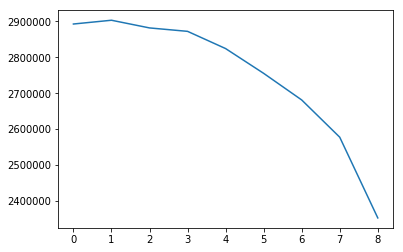

In [39]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

In [40]:
z_vector = make_some_noise(16)
fake_rows = gen(z_vector)

In [41]:
# as we see generator produces very similar vectors 
fake_rows[:,:9]

tensor([[4.8868, 1.5460, 0.7210, 1.4805, 0.4095, 0.4374, 0.4806, 3.3735, 1.0225],
        [4.8789, 1.5455, 0.7268, 1.5061, 0.4186, 0.4383, 0.4850, 3.3887, 1.0240],
        [4.8836, 1.5315, 0.7159, 1.4835, 0.4150, 0.4350, 0.4822, 3.3891, 1.0137],
        [4.8875, 1.5398, 0.7045, 1.4785, 0.4135, 0.4267, 0.4763, 3.3770, 0.9928],
        [4.8858, 1.5279, 0.7118, 1.4874, 0.4094, 0.4289, 0.4770, 3.3779, 1.0195],
        [4.8908, 1.5127, 0.6953, 1.4771, 0.3993, 0.4179, 0.4710, 3.3937, 0.9897],
        [4.8864, 1.5381, 0.7168, 1.4804, 0.4123, 0.4347, 0.4813, 3.3925, 1.0239],
        [4.8842, 1.5410, 0.7243, 1.4942, 0.4142, 0.4341, 0.4793, 3.3849, 1.0151],
        [4.8890, 1.5223, 0.7087, 1.4809, 0.4029, 0.4261, 0.4709, 3.3784, 1.0046],
        [4.8877, 1.5274, 0.7066, 1.4709, 0.4111, 0.4311, 0.4694, 3.3765, 1.0135],
        [4.8861, 1.5244, 0.7153, 1.4758, 0.4117, 0.4269, 0.4723, 3.3905, 0.9996],
        [4.8851, 1.5422, 0.7192, 1.4801, 0.4133, 0.4348, 0.4783, 3.3800, 1.0221],
        [4.8875,

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.init as init
from os.path import isfile, isdir, join
import os
# from tensorboard_logger import configure, log_value

In [43]:
# lrD = 5e-4
# lrG = 5e-4
# batch_size = 100
# cuda = True
# epochs = 1000
# device = 5
# seed = 42
# nz = 100
# d_iter = 5
# g_iter = 1
# lamba = 1e-2 # constant for L2 penalty (diversity)
# name = "mnist-experiment"
# # configure("runs/run-" + args.name, flush_secs=5)
# torch.manual_seed(seed)
# # if cuda:
# # #     torch.cuda.set_device('cuda')
# #     torch.cuda.manual_seed(seed)
# # data_loader = torch.utils.data.DataLoader(
# # datasets.MNIST('../data', train=True, download=True,
# # transform=transforms.Compose([transforms.ToTensor(),])), batch_size=batch_size, shuffle=True)

In [66]:
lrD = 5e-4
lrG = 5e-4
batch_size = 100
cuda = True
epochs = 60 #change
device = 5
seed = 1
nz = 10
d_iter = 5
g_iter = 1
lamba = 1e-2 # constant for L2 penalty (diversity)
name = "mnist-experiment"
# configure("runs/run-" + args.name, flush_secs=5)
torch.manual_seed(seed)


data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    ])), batch_size=batch_size, shuffle=True)

In [67]:
# length=6
# batch_size=5

In [68]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(features_length, 1024)
        # bottom
        self.b1 = torch.nn.Linear(features_length, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, features_length)
    def forward(self, xr, xf):
        # get filt
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x
        
# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, features_length),
#     torch.nn.Sigmoid()*5
#     )

class NetG(nn.Module):
    
    def __init__(self):

        super(NetG, self).__init__()

        self.net = nn.Sequential(
                                 nn.Linear(nz,1024),
                                 nn.ReLU(),
                                 nn.Linear(1024,features_length),
                                 nn.Sigmoid()
                                    )
        
    def forward(self, x):
        x = self.net(x)
        return x*5 # to get values in range [0,5]
    
# networks
netD = NetD(use_cuda=False)
netG = NetG()
print(netG)
print(netD)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
one = torch.FloatTensor([1])
mone = one * -1

NetG(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3706, bias=True)
    (3): Sigmoid()
  )
)
NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)


In [69]:
# class NetD(torch.nn.Module):
#     def __init__(self, use_cuda=True):
#         super(NetD, self).__init__()
#         self.use_cuda = use_cuda
#         # top
#         self.t1 = torch.nn.Linear(length, 1024)
#         # bottom
#         self.b1 = torch.nn.Linear(length, 1024)
#         # combined
#         self.fc = torch.nn.Linear(2 * 1024, length)
#     def forward(self, xr, xf):
#         # get filt
# #         print("##########"*40)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
# #         if (filt == xr * xf).all():
# #             print('AAAAAAAAAAAAAAAAAAAAAAAAAA')
            
# #         print('xr & xf', xr * xf)
# #         print('filt', filt)
# #         print('xr.shape, xf.shape', xr.shape, xf.shape)
# #         print('filt.shape', filt.shape)
# #         print('xr', xr)
# #         print('xf', xf)
# #         print('filt', filt)
# # #         return filt
# #         # random swap
#         idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
# #         print(idr.shape)
# #         print('idr', idr)
#         idrx = idr.float().unsqueeze(1).expand_as(xr)
# #         print('idrx', idrx)
# #         print('idrx.shape', idrx.shape)
# #         print('idrx', idrx[10:20, 100:200])
#         if self.use_cuda: 
#             idrx = idrx.cuda()
#         idrx = Variable(idrx)
# #         print('xr.shape', xr.shape)
# #         print('xr', xr[10:20, 100:200])
# #         print('xr*idrx.shape', (xr*idrx).shape)
# #         print('xr*idrx', (xr*idrx)[10:20, 100:200])
# #         print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', xr * idrx == xr)
# #         for c in xr * idrx == xr:
# #             print(c)
#         xt = xr * idrx + xf * (1 - idrx)
#         xb = xr * (1 - idrx) + xf * idrx
# #         print('xt', xt)
# #         print('xb', xb)
#         # top : real
#         xt = F.relu(self.t1(xt))
#         # bottom : fake
#         xb = F.relu(self.b1(xb))
#         # combined
# #         print(xt.shape, xb.shape)
#         x = torch.cat((xt, xb), 1)
# #         print('x', x)
#         x = torch.tanh(self.fc(x))
# #         print('xxxx', x.shape)
# #         print('x[:, :10]', x[:10, :10])
# #         print('filt', filt[:10, :10])
#         # apply filter, aggregate
# #         print('x[:, :10]', x[:10, :10])
# #         print('filt', filt[:10, :10])
#         x = filt * x
# #         print('x', x)
# #         print('x[:, :10]', x[:10, :10])
# #         print('xxxx', x.shape)
# #         print('x', x[:10, :10])
# #         print(x.mean(dim = 1).shape, x.mean(dim = 1))
#         x = x.mean(dim = 1).squeeze()
# #         print('x', x)
# #         print('xxxx', x.shape)
#         # use sign, because of swapping
#         sgn = idr * 2 - 1
#         if self.use_cuda: 
#             sgn = sgn.cuda()
#         sgn = Variable(sgn.float())
#         x = sgn * x
# #         print('x', x)
# #         print("##########"*40)
#         return x

In [70]:
# # latent_vec_size = 100
# # vec_size = 1000

# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, length),
#     torch.nn.Sigmoid()
#     )

In [71]:
# # networks
# netD = NetD(False)
# print(netG)
# print(netD)
# optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)
# optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
# one = torch.FloatTensor([1])
# mone = one * -1

In [72]:
one = torch.FloatTensor([1])
mone = one * -1
cuda = False
if cuda is True:
    netD.cuda()
    netG.cuda()
    one, mone = one.cuda(), mone.cuda()

In [73]:
for p in netD.parameters(): # reset requires_grad
    p.requires_grad = True #
    
for p in netG.parameters(): # reset requires_grad
    p.requires_grad = True #

In [74]:
# batch_size = 5

In [75]:
def getRealSample(length=6):
     return Variable(torch.IntTensor(np.random.choice([0, 1], size=(batch_size, length))))

In [76]:
get_random_batch(train, batch_size=batch_size).shape

torch.Size([100, 3706])

In [77]:
len(data_loader)

600

In [78]:
steps_per_epoch = 100
gen_iterations = 0
eval_losses = []
for epoch in range(epochs):
#     data_iter = iter(data_loader)
    i = 0
    while i < steps_per_epoch:
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        d_iter = d_iter
        j = 0
        while j < d_iter and i < len(data_loader):
            j += 1
            # load real data
            i += 1
#             X, _ = data_iter.next()
            X = get_random_batch(train, batch_size=batch_size)
#             print(X >= 0.5)
# #             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            # generate fake data
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
#             print(real.shape, fake.shape)
    
            # compute gradient, take step
            netD.zero_grad()
#             print('real', real)
#             print('fake', fake[:,0].sum())
            out = netD(real, fake)
            
            outputD = torch.mean(out) + lamba * out.norm()
            stdD = torch.std(out)
            outputD.backward(mone)
            optimizerD.step()
#             print(out.shape)
        ############################
        # (2) Update G network
        ###########################
        g_iter = g_iter
        j = 0
        while j < g_iter and i < len(data_loader):
            j += 1
            for p in netD.parameters():
                p.requires_grad = False # to avoid computation
            netG.zero_grad()
            
            # load real data
            i += 1
            X = get_random_batch(train, batch_size=batch_size)
#             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            
            # update generator
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            noisev = Variable(noise)
            fake = netG(noisev)
            out = netD(real, fake)
            outputG = torch.mean(out) + lamba * out.norm()
            stdG = torch.std(out)
            outputG.backward(one)
            optimizerG.step()

            gen_iterations += 1

#             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
#             print('output_D', outputD.item(), gen_iterations)
#             print('output_G', outputG.item(), gen_iterations)
#             print('std_D', stdD.item(), gen_iterations)
#             print('std_G', stdG.item(), gen_iterations)
            
            # evaluation
            if gen_iterations % 100 == 0: # todo- to change
#                 gen.eval()
#                 z_vector_eval = make_some_noise(128)
#                 fake_rows_eval = gen(z_vector_eval)
#                 real_rows_eval = get_random_batch(train, 128)
        #         print(fake_rows[0][:10]) enable to see some results
                eval_loss = F.mse_loss(fake, real, reduction='mean')
                eval_losses.append(eval_loss)
                print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))

#     #         print(gen_iterations)
#             if gen_iterations % 100 == 0:
#                 if not isdir('./images/{0}'.format(name)):
#                     os.makedirs('./images/{0}'.format(name))
#                 real = real.data[0:100,:]
#                 real = real.view(real.size(0), 1, 28, 28)
#                 vutils.save_image(real, './images/{0}/real_samples.png'.format(name, gen_iterations))
#                 noise = torch.randn(min(100, batch_size), nz)
#                 if cuda: 
#                     noise = noise.cuda()
#                 fake = netG(Variable(noise, volatile=True))
# #                 print('real', real)
# #                 print('fake', fake)
#                 # fake = (fake.data >= 0.5).float()
#                 R = torch.rand(fake.size())
#                 fake = (fake.data.cpu() >= R).float()
#                 fake = fake.view(fake.size(0), 1, 28, 28)
#                 vutils.save_image(fake, './images/{0}/fake_samples_{1}.png'.format(name, gen_iterations))
#     # do checkpointing
# #     if not isdir('./checkpoint/{0}'.format(name)):
# #         os.makedirs('./checkpoint/{0}'.format(name))
#     torch.save(netG.state_dict(), './checkpoint/{0}/netG_epoch_{1}.pth'.format(name, epoch))
#     torch.save(netD.state_dict(), './checkpoint/{0}/netD_epoch_{1}.pth'.format(name, epoch))

Epoch number 5. MSE distance between random real and fake samples 0.6790403127670288
Epoch number 11. MSE distance between random real and fake samples 0.6927008032798767
Epoch number 17. MSE distance between random real and fake samples 0.7419093251228333
Epoch number 23. MSE distance between random real and fake samples 0.6266229152679443
Epoch number 29. MSE distance between random real and fake samples 0.6402091979980469
Epoch number 35. MSE distance between random real and fake samples 0.6480994820594788
Epoch number 41. MSE distance between random real and fake samples 0.5644475221633911
Epoch number 47. MSE distance between random real and fake samples 0.6449011564254761
Epoch number 52. MSE distance between random real and fake samples 0.619330108165741
Epoch number 58. MSE distance between random real and fake samples 0.548399031162262


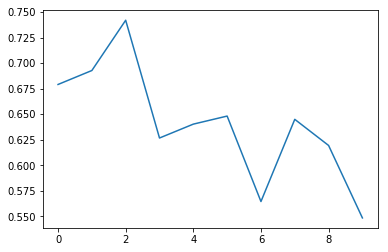

In [80]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

In [81]:
noise = torch.randn(batch_size, nz)
if cuda: 
    noise = noise.cuda()
noisev = Variable(noise)
fake = netG(noisev)

In [82]:
(0 == fake.round()).sum()

tensor(359335)

In [83]:
(5 == fake.round()).sum()

tensor(767)

In [87]:
(4 == fake.round()).sum()

tensor(1152)

In [86]:
(5 == ratings.round()).sum()

226310

In [88]:
(4 == ratings.round()).sum()

348971

In [84]:
# gen_iterations = 0
# for epoch in range(epochs):
# #     data_iter = iter(data_loader)
#     i = 0
#     while i < 10:
#         ############################
#         # (1) Update D network
#         ###########################
#         for p in netD.parameters(): # reset requires_grad
#             p.requires_grad = True # they are set to False below in netG update
#         d_iter = d_iter
#         j = 0
#         while j < d_iter and i < 10:
#             j += 1
#             # load real data
#             i += 1
#             X = getRealSample()
#             X = X.view(X.size(0), -1).float()
# #             X = (X >= 0.5).float()
#             if cuda: 
#                 X = X.cuda()
#             real = Variable(X, requires_grad=True)
#             # generate fake data
#             noise = torch.randn(batch_size, nz)
#             if cuda: 
#                 noise = noise.cuda()
#             with torch.no_grad():
#                 noisev = Variable(noise) # totally freeze netG
#             fake = (Variable(netG(noisev).data, requires_grad=True) > 0.5).float()
#             # compute gradient, take step
#             netD.zero_grad()
#             print(real, fake)
#             out = netD(real, fake)
# #             print(real.shape, fake.shape, out.shape)
#             outputD = torch.mean(out) + lamba * out.norm()
#             stdD = torch.std(out)
# #             print('outputD.shape', outputD)
#             outputD.backward(mone)
#             optimizerD.step()
# #             break
# #         break
# #     break

#             g_iter = g_iter
#             j = 0
#             while j < g_iter and i < 10:
#                 j += 1
#                 for p in netD.parameters():
#                     p.requires_grad = False # to avoid computation
#                 netG.zero_grad()
#                 # load real data
#                 i += 1
#                 X = getRealSample()
#                 X = X.view(X.size(0), -1)
# #                 X = (X >= 0.5).float()
#                 if cuda: 
#                     X = X.cuda()
#                 real = Variable(X.float(), requires_grad=True)
#                 # update generator
#                 noise = torch.randn(batch_size, nz)
#                 if cuda: 
#                     noise = noise.cuda()
#                 noisev = Variable(noise)
#                 fake = Variable((netG(noisev) >=0.5).float(), requires_grad=True)
#                 print("####"*40)
#                 print('REEEEAL', real)
#                 print('FAAAKE', fake)
#                 print("####"*40)
# #                 print(real.shape, fake.shape)
#                 out = netD(real, fake)
#                 outputG = torch.mean(out) + lamba * out.norm()
#                 stdG = torch.std(out)
#                 outputG.backward(one)
#                 optimizerG.step()
#                 gen_iterations += 1

#             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f ' % (epoch, epochs, i, 10, gen_iterations, outputD.data.item(), outputG.data.item()))
#             print('output_D', outputD.data.item(), gen_iterations)
#             print('output_G', outputG.data.item(), gen_iterations)
#             print('std_D', stdD.data.item(), gen_iterations)
#             print('std_G', stdG.data.item(), gen_iterations)
# #             if gen_iterations % 100 == 0:
# #                 if not isdir('./images/{0}'.format(name)):
# #                     os.mkdir('./images/{0}'.format(name))
# #                 real = real.data[0:100,:]
# #                 real = real.view(real.size(0), 1, 28, 28)
# #                 vutils.save_image(real, './images/{0}/real_samples.png'.format(name, gen_iterations))
# #                 noise = torch.randn(min(100, batch_size), nz)
# #                 if cuda: 
# #                     noise = noise.cuda()
# #                 fake = netG(Variable(noise, volatile=True))
# #                 # fake = (fake.data >= 0.5).float()
# #                 R = torch.rand(fake.size())
# #                 fake = (fake.data.cpu() >= R).float()
# #                 fake = fake.view(fake.size(0), 1, 28, 28)
# #                 vutils.save_image(fake, './images/{0}/fake_samples_{1}.png'.format(name, gen_iterations))

# #             # do checkpointing
# #             if not isdir('./checkpoint/{0}'.format(name)):
# #                 os.mkdir('./checkpoint/{0}'.format(name))
# #             torch.save(netG.state_dict(), './checkpoint/{0}/netG_epoch_{1}.pth'.format(name, epoch))
# #             torch.save(netD.state_dict(), './checkpoint/{0}/netD_epoch_{1}.pth'.format(name, epoch))


In [85]:
batch_size

100